# Construção de Rede Neural Artificial com Programação e Matemática

### O segunte projeto consiste em uma atividade do capítulo 13 sobre Redes Neurais Artificiais do curso de Machine Learning da Data Science Academy.

In [1]:
# imports
import sklearn
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
%reload_ext watermark
%watermark --iversions

pandas    : 2.0.2
matplotlib: 3.7.1
sklearn   : 1.2.1
numpy     : 1.23.5



### Construção do Modelo

In [2]:
# forward propagation
# incialização dos parâmetros (pesos e vies)
def inicializar_param(dim_input_layer):
    # dicionario de parâmtros
    param = {}
    for i in range(1,len(dim_input_layer)):
        # matrizes de pesos
        # geralção de valores randomicos com base nas dimensões da camada de entrada
        param["W"+str(i)] = np.random.randn(dim_input_layer[i],dim_input_layer[i-1]) * 0.01
        # bias
        # incializam zerados
        param["b"+str(i)] = np.zeros((dim_input_layer[i],1))
    return param

# função sigmoide: permite converter qualquer valor em um intervalo entre 0 e 1
# sig(t) = 1/(1 + e^(-t))
def sigmoid(Z):
    sig = 1/(1+np.exp(-Z))
    return sig,Z

# função de ativação ReLu
# se Z> 0: func = Z
# se Z<=0: func = 0
def relu(Z):
    func = abs(Z * (Z>0))
    return func, Z

# ativação linear
def linear_activation(A, W, b):
    # A: matriz de entrada
    # W: pesos
    # b: bias/vies
    Z = np.dot(W,A)+b
    # salvar parâmetros da função
    cache = (A,W,b)
    return Z, cache

# função para aplicação de relu e sigmoid
def forward(A_prev, W, b, activation = "relu"):
    if activation == "sigmoid":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = relu(Z)
    cache = (linear_cache,activation_cache)
    return A, cache

# combinando ativação e propagação
def forward_propagation(X, param):
    # lista de valores históricos
    caches = []
    # dados de entrada
    A = X
    # divide-se por 2 pois metade dos parâmetros são pesos e a outra metade são vieses
    L = len(param)//2
    for i in range(1,L):
        # salvar valor previo
        A_prev = A
        # aplicar forward com relu aos valores previos
        A, cache = forward(A_prev,param["W"+str(i)],param["b"+str(i)],activation="relu")
        caches.append(cache)
    # por fim, aplicar forward com sigmoid
    A_last, cache = forward(A,param["W"+str(L)],param["b"+str(L)],activation="sigmoid")
    caches.append(cache)
    return(A_last,caches)
    

In [3]:
# desenvolvendo função de custo
# mede a discrepância entre a distribuição de probabilidade prevista e a distribuição real dos rótulos
def calcula_custo(A_last,Y):
    m = Y.shape[1]
    # função de entropia cruzada binária
    custo = (-1/m)*np.sum((Y *np.log(A_last))+((1-Y)*np.log(1-A_last)))
    # ajustar shape de custo
    custo = np.squeeze(custo)
    return (custo)

In [4]:
# back propagation - aprendizado ocorre aqui
# função sigmoid para o back propagation
def sigmoid_backward(da, Z):
    # calculo da derivada da função sigmoid
    dg = (1/(1+np.exp(-Z))) *(1-(1/(1+np.exp(-Z))))
    return da*dg

# função relu para o back propagation
def relu_backward(da,Z):
    dg = 1 * (Z>=0)
    return da*dg

# função para derivação de A_prev, W e b a partir do cache
def linear_backward_function(dz,cache):
    A_prev,W,b = cache
    m = A_prev.shape[1]
    # derivada de W
    dW = (1/m)*np.dot(dz,A_prev.T)
    # derivada de b
    db = (1/m)*np.sum(dz,axis=1,keepdims=True)
    # derivada de A_prev
    dA_prev = np.dot(W.T,dz)
    return dA_prev,dW,db

# ativação linear no backward propagation
def linear_activation_backward(da, cache, activation = "relu"):
    linear_cache, activation_cache = cache
    if activation == "sigmoid":
        dz = sigmoid_backward(da,activation_cache)
        da_prev,dW,db = linear_backward_function(dz,linear_cache)
    elif activation == "relu":
        dz = relu_backward(da,activation_cache)
        da_prev,dW,db = linear_backward_function(dz,linear_cache)
    return da_prev,dW,db

def backward_propagation(AL,Y,caches):
    # AL: valor previsto no forward
    # Y: valor real
    # dicionário com os gradientes
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    # adequar formato de Y
    Y = Y.reshape(AL.shape)
    dAL = -((Y/AL) - ((1-Y)/(1-AL)))
    # processo inverso do forward propagation
    # percorrimento reverso do cache e aplicação das funções de ativação
    current_cache = caches[L-1]
    grads["dA"+str(L-1)],grads["dW"+str(L)],grads["db"+str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev,dW,db = linear_activation_backward(grads["dA"+str(l+1)],current_cache,activation="relu")
        grads["dA"+str(l)] = dA_prev
        grads["dW"+str(l+1)] = dW
        grads["db"+str(l+1)] = db
    return grads

# atualizar pesos - percorrer pesos e aplicar gradientes correspondentes 
def atualiza_pesos(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters["W"+str(l+1)] = parameters["W"+str(l+1)] - (learning_rate * grads["dW"+str(l+1)])
        parameters["b"+str(l+1)] = parameters["b"+str(l+1)] - (learning_rate * grads["db"+str(l+1)])
    return parameters

In [5]:
# implementação do modelo de rede neural artificial
def modeloRNA(X,Y,dims_input_layer,learning_rate = 0.0075, epochs = 100):
    # lista que recebe o custo de cada epoca
    costs = []
    parametros = inicializar_param(dims_input_layer)
    # loop pelo numero de interações
    for i in range(epochs):
        # forward propagation
        AL, caches = forward_propagation(X,parametros)
        # custo - Valor Previsto X Valor Real
        custo = calcula_custo(AL,Y)
        # backward propagation
        gradientes = backward_propagation(AL,Y,caches)
        # atualizar pesos
        parametros = atualiza_pesos(parametros,gradientes,learning_rate)
        # exibir custos a cada 10 epocas
        if i%10==0:
            print(f"Custo na época {i}: {custo}")
            costs.append(custo)
    return parametros, costs

# previsão - aplicar parametros do modelo a um novo valor
def predict(X, parametros):
    AL, caches = forward_propagation(X,parametros)
    return AL

### Teste do Modelo

In [6]:
# carregando dados
temp = load_breast_cancer()
dados = pd.DataFrame(columns=temp["feature_names"],data = temp["data"])

In [7]:
# checar valores ausentes
dados.isna().any()

mean radius                False
mean texture               False
mean perimeter             False
mean area                  False
mean smoothness            False
mean compactness           False
mean concavity             False
mean concave points        False
mean symmetry              False
mean fractal dimension     False
radius error               False
texture error              False
perimeter error            False
area error                 False
smoothness error           False
compactness error          False
concavity error            False
concave points error       False
symmetry error             False
fractal dimension error    False
worst radius               False
worst texture              False
worst perimeter            False
worst area                 False
worst smoothness           False
worst compactness          False
worst concavity            False
worst concave points       False
worst symmetry             False
worst fractal dimension    False
dtype: boo

In [8]:
# variável target
target = temp["target"]

In [9]:
# cancer benigno
print("Cancer Benigno: ",np.count_nonzero(target==1))

# cancer maligno
print("Cancer Maligno: ",np.count_nonzero(target==0))

labels = {}
target_names = temp["target_names"]
for i in range(len(target_names)):
    labels.update({i:target_names[i]})
# outra opção: labels = {i:temp["target_names"][i] for i in range(len(temp["target_names"]))}
print(labels)

Cancer Benigno:  357
Cancer Maligno:  212
{0: 'malignant', 1: 'benign'}


In [10]:
# converter dados para array numpy
X = np.array(dados)

# separar dados de treine e teste
X_treino,X_teste,Y_treino,Y_teste = train_test_split(X, target,test_size=0.15,shuffle=True)

# ajustar shape
X_treino = X_treino.T
X_teste = X_teste.T
Y_treino = Y_treino.reshape(1,len(Y_treino))
Y_teste = Y_teste.reshape(1,len(Y_teste))

# dimensão das camadas de entrada
dim_input_layers = [X_treino.shape[0],50,20,5,1]

In [11]:
# treinamento
print("Inicio do Treinamento!")
parametros,custo = modeloRNA(X = X_treino,Y = Y_treino,dims_input_layer=dim_input_layers,epochs=3000)
print("Treinamento Concluido!")

Inicio do Treinamento!
Custo na época 0: 0.6931553127494279
Custo na época 10: 0.6920701696118343
Custo na época 20: 0.6910244223403428
Custo na época 30: 0.6900166784408416
Custo na época 40: 0.6890456506559621
Custo na época 50: 0.6881099661385863
Custo na época 60: 0.6872081675759485
Custo na época 70: 0.686338888147652
Custo na época 80: 0.6855009467579971
Custo na época 90: 0.6846931259671956
Custo na época 100: 0.6839141831684546
Custo na época 110: 0.6831630360921428
Custo na época 120: 0.6824386188921057
Custo na época 130: 0.6817400078263651
Custo na época 140: 0.6810660165468233
Custo na época 150: 0.6804154731200421
Custo na época 160: 0.6797873064881381
Custo na época 170: 0.6791805324707534
Custo na época 180: 0.6785941714011003
Custo na época 190: 0.6780273476701479
Custo na época 200: 0.6774792517664495
Custo na época 210: 0.6769488873715443
Custo na época 220: 0.6764348375710821
Custo na época 230: 0.6759357522698115
Custo na época 240: 0.6754506202628626
Custo na época

Custo na época 2100: 0.2501164492760335
Custo na época 2110: 0.24912446066155847
Custo na época 2120: 0.24858512810189284
Custo na época 2130: 0.2486463593325093
Custo na época 2140: 0.248422336710955
Custo na época 2150: 0.2461354598918584
Custo na época 2160: 0.2479334799075629
Custo na época 2170: 0.2465061905186089
Custo na época 2180: 0.24737165977815076
Custo na época 2190: 0.24666649733992435
Custo na época 2200: 0.24577035501463593
Custo na época 2210: 0.24581397927058618
Custo na época 2220: 0.24549592017231964
Custo na época 2230: 0.24439314712623514
Custo na época 2240: 0.24404793459323937
Custo na época 2250: 0.24397031889176493
Custo na época 2260: 0.2436316561133319
Custo na época 2270: 0.2429673373831161
Custo na época 2280: 0.24294932097597005
Custo na época 2290: 0.2419968972503137
Custo na época 2300: 0.24202669881253935
Custo na época 2310: 0.2419942850143317
Custo na época 2320: 0.24115664257138134
Custo na época 2330: 0.2412553435548982
Custo na época 2340: 0.24108

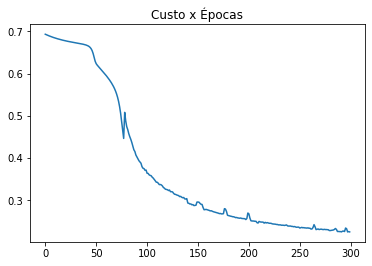

In [12]:
# plotagem do custo
plt.plot(custo)
plt.title("Custo x Épocas")
plt.show()

In [13]:
y_pred_treino = predict(X_treino,parametros)
y_pred_treino = y_pred_treino.reshape(-1)
Y_treino = Y_treino.reshape(-1)
y_pred_treino = 1* (y_pred_treino>0.5)
accuracy_train = sum(1 * (y_pred_treino == Y_treino))/len(y_pred_treino)*100
print(f"Acurácia do modelo em treinamento: {accuracy_train}")

Acurácia do modelo em treinamento: 92.33954451345755


In [14]:
print(classification_report(Y_treino,y_pred_treino,target_names=["Maligno","Benigno"]))

              precision    recall  f1-score   support

     Maligno       0.91      0.89      0.90       183
     Benigno       0.93      0.94      0.94       300

    accuracy                           0.92       483
   macro avg       0.92      0.92      0.92       483
weighted avg       0.92      0.92      0.92       483



In [15]:
y_pred_teste = predict(X_teste,parametros)
y_pred_teste = y_pred_teste.reshape(-1)
Y_teste = Y_teste.reshape(-1)
y_pred_teste = 1* (y_pred_teste>0.5)
accuracy_test = sum(1 * (y_pred_teste == Y_teste))/len(y_pred_teste)*100
print(f"Acurácia do modelo em teste: {accuracy_test}")

Acurácia do modelo em teste: 90.69767441860465


In [16]:
print(classification_report(Y_teste,y_pred_teste,target_names=["Maligno","Benigno"]))

              precision    recall  f1-score   support

     Maligno       0.86      0.86      0.86        29
     Benigno       0.93      0.93      0.93        57

    accuracy                           0.91        86
   macro avg       0.90      0.90      0.90        86
weighted avg       0.91      0.91      0.91        86

